In [24]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import keras.optimizers as optimizers
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
warnings.filterwarnings("ignore")

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train, test = detect_nan(train), detect_nan(test)
train, test = solve_nan(train), solve_nan(test)
data = pd.concat([train, test], axis=0, ignore_index=True)

features = [f for f in data.columns if f not in ['是否流失','客户ID']]
train = data[data['是否流失'].notnull()].reset_index(drop=True)
test = data[data['是否流失'].isnull()].reset_index(drop=True)
x_train = train[features]
x_test = test[features]

y_train = train['是否流失']

In [3]:
def solve_nan(df):
    nan_num_cols = ['当前手机价格', '家庭成人人数', '预计收入', '当前设备使用天数', '平均月费用', '每月平均使用分钟数', 
                    '平均超额使用分钟数', '平均超额费用', '平均语音费用', '数据超载的平均费用', '平均漫游呼叫数', 
                    '当月使用分钟数与前三个月平均值的百分比变化','当月费用与前三个月平均值的百分比变化', 
                    '过去六个月的平均每月使用分钟数', '过去六个月的平均每月通话次数', '过去六个月的平均月费用']
    for col in nan_num_cols:
        df[col].fillna(int(df[col].mean()), inplace=True)
        
    nan_cat_cols = ['地理区域', '是否双频', '是否翻新机', '手机网络功能', '婚姻状况', '信息库匹配', '信用卡指示器']
    for col in nan_cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

In [4]:
def detect_nan(df):
    df = df.replace(-1,np.NaN)
    non_negative_cols = ['当前设备使用天数', '平均月费用']
    for col in non_negative_cols:
        df.loc[~(df[col] > 0), col] = np.nan
    return df

In [11]:
x_train.head()

,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,信用卡指示器,...,计费调整后的呼叫总数,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用
0,7.0,0.0,0.0,181.0,0.0,2.0,0.0,0.0,3.0,1.0,...,855,24,286,91,351,121,23,303.0,101.0,25.0
1,13.0,1.0,0.0,1399.0,0.0,3.0,0.0,0.0,0.0,1.0,...,1936,44,447,190,483,199,40,488.0,202.0,44.0
2,14.0,1.0,0.0,927.0,0.0,2.0,4.0,0.0,6.0,0.0,...,1963,48,183,79,271,95,71,209.0,77.0,54.0
3,1.0,0.0,0.0,232.0,0.0,3.0,2.0,1.0,4.0,1.0,...,3917,42,303,166,473,226,72,446.0,219.0,65.0
4,0.0,1.0,0.0,699.0,0.0,1.0,2.0,0.0,3.0,0.0,...,248,36,119,24,88,15,35,106.0,21.0,37.0


In [13]:
print(train['是否流失'].value_counts())
print('')
print(x_train.shape)
print('')
print(f'the number of rows containing NaN is {x_train.shape[0] - x_train.dropna().shape[0]}')

1.0    75042
0.0    74958
Name: 是否流失, dtype: int64

(150000, 67)

the number of rows containing NaN is 0


In [12]:
def preprocessor(df):
   # Dict for aggregations
    create_feature_dict = {
        '当前手机价格': [np.sum, np.std],               #### 去掉np.mean
        '家庭成人人数': [np.sum, np.std],               #### 去掉np.mean
        '预计收入': [np.sum, np.std],               #### 加入wap3 [np.sum, np.std]
        '当前设备使用天数': [np.sum, np.std],               #### 加入wap4 [np.sum, np.std]
        '平均月费用': [np.sum, np.std],
        'log_return1': [realized_volatility],   #### 去掉np.sum, np.mean, np.std
        'log_return2': [realized_volatility],   #### 去掉np.sum, np.mean, np.std
        'log_return3': [realized_volatility],   #### 加入 'log_return3': [realized_volatility]
        'log_return4': [realized_volatility],   #### 加入 'log_return4': [realized_volatility]
        'wap_balance': [np.sum, np.max],        #### 去掉np.mean, np.std,加入了np.max
        'price_spread':[np.sum, np.max],        #### 去掉np.mean, np.std,加入了np.max
        'price_spread2':[np.sum, np.max],       #### 去掉np.mean, np.std,加入了np.max
        'bid_spread':[np.sum, np.max],          #### 去掉np.mean, np.std,加入了np.max
        'ask_spread':[np.sum, np.max],          #### 去掉np.mean, np.std,加入了np.max
        'total_volume':[np.sum, np.max],        #### 去掉np.mean, np.std,加入了np.max
        'volume_imbalance':[np.sum, np.max],    #### 去掉np.mean, np.std,加入了np.max
        "bid_ask_spread":[np.sum,  np.max],     #### 去掉np.mean, np.std,加入了np.max
    }    

客户ID               0
地理区域               0
是否双频               0
是否翻新机              0
当前手机价格             0
                  ..
过去三个月的平均月费用        0
过去六个月的平均每月使用分钟数    0
过去六个月的平均每月通话次数     0
过去六个月的平均月费用        0
是否流失               0
Length: 69, dtype: int64

In [91]:
x_train.describe()

,地理区域,是否双频,是否翻新机,当前手机价格,手机网络功能,婚姻状况,家庭成人人数,信息库匹配,预计收入,信用卡指示器,...,计费调整后的呼叫总数,客户生命周期内平均月费用,客户生命周期内的平均每月使用分钟数,客户整个生命周期内的平均每月通话次数,过去三个月的平均每月使用分钟数,过去三个月的平均每月通话次数,过去三个月的平均月费用,过去六个月的平均每月使用分钟数,过去六个月的平均每月通话次数,过去六个月的平均月费用
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,8.060327,0.618253,-0.094287,705.279413,0.286100,1.629427,1.582027,0.136187,3.906173,0.198140,...,2850.812660,56.727240,479.829973,171.989867,515.756253,179.328827,58.243247,492.528440,172.607533,56.273753
std,5.065028,0.539597,0.292228,419.211310,0.587749,1.231911,1.714654,0.346488,3.156789,0.420018,...,3763.973391,34.368247,427.972362,163.881701,520.295608,187.742919,43.516844,486.577663,178.694606,39.150687
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000
25%,4.000000,0.000000,0.000000,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,870.000000,35.000000,177.000000,64.000000,154.000000,56.000000,33.000000,150.000000,55.000000,34.000000
50%,8.000000,1.000000,0.000000,699.000000,0.000000,1.000000,1.000000,0.000000,5.000000,0.000000,...,1795.000000,49.000000,361.000000,127.000000,358.000000,126.000000,48.000000,350.000000,123.000000,48.000000
75%,12.000000,1.000000,0.000000,1049.000000,0.000000,3.000000,3.000000,0.000000,6.000000,0.000000,...,3467.000000,68.000000,655.000000,227.000000,708.000000,239.000000,69.000000,681.000000,232.000000,68.000000
max,18.000000,1.000000,0.000000,3499.000000,2.000000,4.000000,6.000000,1.000000,9.000000,1.000000,...,97997.000000,902.000000,7040.000000,2716.000000,7716.000000,3261.000000,1593.000000,7217.000000,2887.000000,866.000000


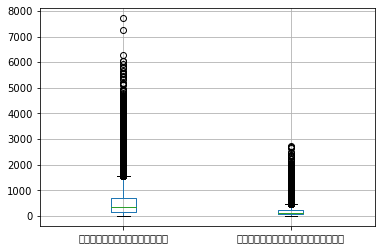

In [14]:
boxplot = train.boxplot(column=['过去三个月的平均每月使用分钟数', '客户整个生命周期内的平均每月通话次数'])  

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [53]:
def objective(trial):
    xgb_params = {
        # 'objective':'auc',
        'n_jobs':-1,
        'seed': 42,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        
        
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 6),
        
        'max_bin':trial.suggest_categorical("max_bin", [256, 512]),
        'colsample_bytree':trial.suggest_categorical("colsample_bytree", [0.6, 0.7, 0.8, 0.9, 1]),
        'colsample_bylevel':trial.suggest_categorical("colsample_bylevel", [0.6, 0.7, 0.8, 0.9, 1]),
        'eta': trial.suggest_loguniform("eta", 0.008, 0.3),
        #"n_estimators":trial.suggest_categorical("n_estimators", [400, 500, 600, 800, 1000]),
        "max_depth":trial.suggest_int("max_depth", 3, 10), 
        'gamma': trial.suggest_categorical('gamma', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1]),
        'reg_lambda': trial.suggest_categorical('reg_lambda', [0.05, 0.1, 1, 2, 3, 5, 10])
    }
    
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    cv_scores = []
    for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
        print(f'-----------------------{str(i+1)}------------------------')
        trn_x, trn_y = x_train.iloc[train_index], y_train.loc[train_index]
        val_x, val_y = x_train.iloc[valid_index], y_train.loc[valid_index]
        
        train_matrix = xgb.DMatrix(trn_x, label=trn_y)
        valid_matrix = xgb.DMatrix(val_x, label=val_y)
        
        watchlist = [(train_matrix, 'train'), (valid_matrix, 'eval')]
        
        model = xgb.train(xgb_params, train_matrix, num_boost_round=200, evals=watchlist, 
                          verbose_eval=200, early_stopping_rounds=200)
        val_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
    return np.mean(cv_scores)

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
trial = study.best_trial
print('Best trial:', trial.params)
print('Best Score:', trial.value)

[I 2022-10-28 00:12:58,246] A new study created in memory with name: no-name-e29fa72f-5f18-45dd-a302-2cf187d38f3d


-----------------------1------------------------
[0]	train-auc:0.67852	eval-auc:0.64828
[199]	train-auc:0.78656	eval-auc:0.70375
-----------------------2------------------------
[0]	train-auc:0.67391	eval-auc:0.64726
[199]	train-auc:0.78367	eval-auc:0.70334


[I 2022-10-28 00:13:25,637] Trial 0 finished with value: 0.703543094300059 and parameters: {'min_child_weight': 4, 'max_bin': 512, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6, 'eta': 0.014116974008422496, 'max_depth': 8, 'gamma': 0.2, 'reg_lambda': 0.05}. Best is trial 0 with value: 0.703543094300059.


-----------------------1------------------------
[0]	train-auc:0.67123	eval-auc:0.61962
[199]	train-auc:0.92496	eval-auc:0.73683
-----------------------2------------------------
[0]	train-auc:0.67673	eval-auc:0.61646
[199]	train-auc:0.92483	eval-auc:0.73705


[I 2022-10-28 00:13:58,209] Trial 1 finished with value: 0.736937054089312 and parameters: {'min_child_weight': 4, 'max_bin': 256, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'eta': 0.03251443301447361, 'max_depth': 10, 'gamma': 0.3, 'reg_lambda': 0.1}. Best is trial 1 with value: 0.736937054089312.


-----------------------1------------------------
[0]	train-auc:0.61091	eval-auc:0.60855
[199]	train-auc:0.65973	eval-auc:0.65401
-----------------------2------------------------
[0]	train-auc:0.60848	eval-auc:0.60894
[199]	train-auc:0.65852	eval-auc:0.65422


[I 2022-10-28 00:14:12,659] Trial 2 finished with value: 0.6541151233221834 and parameters: {'min_child_weight': 6, 'max_bin': 512, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.012292387403798653, 'max_depth': 3, 'gamma': 0.2, 'reg_lambda': 10}. Best is trial 1 with value: 0.736937054089312.


-----------------------1------------------------
[0]	train-auc:0.59951	eval-auc:0.59170
[199]	train-auc:0.74473	eval-auc:0.69996
-----------------------2------------------------
[0]	train-auc:0.59756	eval-auc:0.59036
[199]	train-auc:0.74485	eval-auc:0.69990


[I 2022-10-28 00:14:30,483] Trial 3 finished with value: 0.6999279500111197 and parameters: {'min_child_weight': 3, 'max_bin': 256, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.05958184926485061, 'max_depth': 5, 'gamma': 0.1, 'reg_lambda': 3}. Best is trial 1 with value: 0.736937054089312.


-----------------------1------------------------
[0]	train-auc:0.56927	eval-auc:0.56551
[199]	train-auc:0.69344	eval-auc:0.68019
-----------------------2------------------------
[0]	train-auc:0.57629	eval-auc:0.57173
[199]	train-auc:0.69340	eval-auc:0.68128


[I 2022-10-28 00:14:44,928] Trial 4 finished with value: 0.6807348766703846 and parameters: {'min_child_weight': 4, 'max_bin': 256, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'eta': 0.047982827183448734, 'max_depth': 3, 'gamma': 1, 'reg_lambda': 5}. Best is trial 1 with value: 0.736937054089312.


-----------------------1------------------------
[0]	train-auc:0.66401	eval-auc:0.64493
[199]	train-auc:0.76665	eval-auc:0.70194
-----------------------2------------------------
[0]	train-auc:0.66398	eval-auc:0.64433
[199]	train-auc:0.76583	eval-auc:0.70258


[I 2022-10-28 00:15:08,843] Trial 5 finished with value: 0.7022589770581281 and parameters: {'min_child_weight': 6, 'max_bin': 256, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'eta': 0.022858556419438996, 'max_depth': 7, 'gamma': 0.5, 'reg_lambda': 3}. Best is trial 1 with value: 0.736937054089312.


-----------------------1------------------------
[0]	train-auc:0.69773	eval-auc:0.65128
[199]	train-auc:0.97164	eval-auc:0.74418
-----------------------2------------------------
[0]	train-auc:0.70422	eval-auc:0.64643
[199]	train-auc:0.97412	eval-auc:0.74670


[I 2022-10-28 00:15:38,921] Trial 6 finished with value: 0.7454397372058783 and parameters: {'min_child_weight': 3, 'max_bin': 256, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.14328024544617263, 'max_depth': 9, 'gamma': 0.6, 'reg_lambda': 2}. Best is trial 6 with value: 0.7454397372058783.


-----------------------1------------------------
[0]	train-auc:0.61337	eval-auc:0.60220
[199]	train-auc:0.86688	eval-auc:0.71947
-----------------------2------------------------
[0]	train-auc:0.61050	eval-auc:0.59857
[199]	train-auc:0.87201	eval-auc:0.71934


[I 2022-10-28 00:15:57,221] Trial 7 finished with value: 0.7194038022549898 and parameters: {'min_child_weight': 3, 'max_bin': 256, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'eta': 0.26127971525657734, 'max_depth': 6, 'gamma': 0.2, 'reg_lambda': 10}. Best is trial 6 with value: 0.7454397372058783.


-----------------------1------------------------
[0]	train-auc:0.68746	eval-auc:0.65342
[199]	train-auc:0.97026	eval-auc:0.74213
-----------------------2------------------------
[0]	train-auc:0.68587	eval-auc:0.65487
[199]	train-auc:0.97588	eval-auc:0.74421


[I 2022-10-28 00:16:26,714] Trial 8 finished with value: 0.7431663037607317 and parameters: {'min_child_weight': 3, 'max_bin': 256, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.2732811812864732, 'max_depth': 8, 'gamma': 0.2, 'reg_lambda': 10}. Best is trial 6 with value: 0.7454397372058783.


-----------------------1------------------------
[0]	train-auc:0.62668	eval-auc:0.62393
[199]	train-auc:0.70456	eval-auc:0.68569
-----------------------2------------------------
[0]	train-auc:0.62767	eval-auc:0.62624
[199]	train-auc:0.70463	eval-auc:0.68671


[I 2022-10-28 00:16:43,725] Trial 9 finished with value: 0.6862017043300189 and parameters: {'min_child_weight': 4, 'max_bin': 256, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.03494976799454682, 'max_depth': 4, 'gamma': 0.2, 'reg_lambda': 10}. Best is trial 6 with value: 0.7454397372058783.


-----------------------1------------------------
[0]	train-auc:0.72175	eval-auc:0.65263
[199]	train-auc:0.98674	eval-auc:0.75526
-----------------------2------------------------
[0]	train-auc:0.73190	eval-auc:0.64934
[199]	train-auc:0.98815	eval-auc:0.75926


[I 2022-10-28 00:17:18,382] Trial 10 finished with value: 0.7572593422099188 and parameters: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.10394472830834614, 'max_depth': 10, 'gamma': 0.6, 'reg_lambda': 2}. Best is trial 10 with value: 0.7572593422099188.


-----------------------1------------------------
[0]	train-auc:0.72175	eval-auc:0.65263
[199]	train-auc:0.98915	eval-auc:0.75636
-----------------------2------------------------
[0]	train-auc:0.73190	eval-auc:0.64934
[199]	train-auc:0.98984	eval-auc:0.75780


[I 2022-10-28 00:17:53,530] Trial 11 finished with value: 0.7570808456927267 and parameters: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.10508418225701165, 'max_depth': 10, 'gamma': 0.6, 'reg_lambda': 2}. Best is trial 10 with value: 0.7572593422099188.


-----------------------1------------------------
[0]	train-auc:0.72175	eval-auc:0.65263
[199]	train-auc:0.98174	eval-auc:0.75400
-----------------------2------------------------
[0]	train-auc:0.73190	eval-auc:0.64934
[199]	train-auc:0.98431	eval-auc:0.75550


[I 2022-10-28 00:18:28,789] Trial 12 finished with value: 0.7547522879169724 and parameters: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.09099325998636898, 'max_depth': 10, 'gamma': 0.6, 'reg_lambda': 2}. Best is trial 10 with value: 0.7572593422099188.


-----------------------1------------------------
[0]	train-auc:0.72096	eval-auc:0.65138
[199]	train-auc:0.99482	eval-auc:0.76069
-----------------------2------------------------
[0]	train-auc:0.73205	eval-auc:0.64819
[199]	train-auc:0.99587	eval-auc:0.76177


[I 2022-10-28 00:19:03,809] Trial 13 finished with value: 0.761232467522063 and parameters: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.12562144582228274, 'max_depth': 10, 'gamma': 0.4, 'reg_lambda': 1}. Best is trial 13 with value: 0.761232467522063.


-----------------------1------------------------
[0]	train-auc:0.69777	eval-auc:0.65039
[199]	train-auc:0.98369	eval-auc:0.74900
-----------------------2------------------------
[0]	train-auc:0.70533	eval-auc:0.64698
[199]	train-auc:0.98155	eval-auc:0.74952


[I 2022-10-28 00:19:36,520] Trial 14 finished with value: 0.7492584124228351 and parameters: {'min_child_weight': 2, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.15072356758940458, 'max_depth': 9, 'gamma': 0.4, 'reg_lambda': 1}. Best is trial 13 with value: 0.761232467522063.


-----------------------1------------------------
[0]	train-auc:0.63958	eval-auc:0.61243
[199]	train-auc:0.90026	eval-auc:0.72917
-----------------------2------------------------
[0]	train-auc:0.64173	eval-auc:0.60887
[199]	train-auc:0.90824	eval-auc:0.73216


[I 2022-10-28 00:20:01,968] Trial 15 finished with value: 0.7306634445374618 and parameters: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'eta': 0.07709739108050086, 'max_depth': 8, 'gamma': 0.4, 'reg_lambda': 1}. Best is trial 13 with value: 0.761232467522063.


-----------------------1------------------------
[0]	train-auc:0.69683	eval-auc:0.64990
[199]	train-auc:0.98439	eval-auc:0.74921
-----------------------2------------------------
[0]	train-auc:0.69983	eval-auc:0.65058
[199]	train-auc:0.98347	eval-auc:0.74831


[I 2022-10-28 00:20:32,472] Trial 16 finished with value: 0.7487597115727924 and parameters: {'min_child_weight': 2, 'max_bin': 512, 'colsample_bytree': 0.8, 'colsample_bylevel': 1, 'eta': 0.1545799181772773, 'max_depth': 9, 'gamma': 0.4, 'reg_lambda': 1}. Best is trial 13 with value: 0.761232467522063.


-----------------------1------------------------
[0]	train-auc:0.66524	eval-auc:0.64352
[199]	train-auc:0.92743	eval-auc:0.72710
-----------------------2------------------------
[0]	train-auc:0.66590	eval-auc:0.64570
[199]	train-auc:0.92973	eval-auc:0.72824


[I 2022-10-28 00:20:56,942] Trial 17 finished with value: 0.727666653507762 and parameters: {'min_child_weight': 2, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.19643799646904883, 'max_depth': 7, 'gamma': 1, 'reg_lambda': 0.1}. Best is trial 13 with value: 0.761232467522063.


-----------------------1------------------------
[0]	train-auc:0.65155	eval-auc:0.63789
[199]	train-auc:0.83764	eval-auc:0.71609
-----------------------2------------------------
[0]	train-auc:0.65174	eval-auc:0.64371
[199]	train-auc:0.83775	eval-auc:0.71695


[I 2022-10-28 00:21:19,251] Trial 18 finished with value: 0.7165212899840692 and parameters: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.11311314747760585, 'max_depth': 6, 'gamma': 0.3, 'reg_lambda': 0.05}. Best is trial 13 with value: 0.761232467522063.


-----------------------1------------------------
[0]	train-auc:0.71608	eval-auc:0.65484
[199]	train-auc:0.94337	eval-auc:0.74120
-----------------------2------------------------
[0]	train-auc:0.72566	eval-auc:0.64997
[199]	train-auc:0.94509	eval-auc:0.74262


[I 2022-10-28 00:21:54,670] Trial 19 finished with value: 0.7419106292901951 and parameters: {'min_child_weight': 2, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.06075113424441491, 'max_depth': 10, 'gamma': 0.5, 'reg_lambda': 5}. Best is trial 13 with value: 0.761232467522063.


Number of finished trials: 20
Best trial: {'min_child_weight': 1, 'max_bin': 512, 'colsample_bytree': 1, 'colsample_bylevel': 0.8, 'eta': 0.12562144582228274, 'max_depth': 10, 'gamma': 0.4, 'reg_lambda': 1}
Best Score: 0.761232467522063


In [57]:
Best_trial = {'seed':42,
              'n_jobs':-1,
              'eval_metric': 'auc',
              'objective': 'binary:logistic',
              'min_child_weight': 1, 
              'max_bin': 512, 
              'colsample_bytree': 1, 
              'colsample_bylevel': 0.8, 
              'eta': 0.12562144582228274, 
              'max_depth': 10, 
              'gamma': 0.4, 
              'reg_lambda': 1}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
test = np.zeros(x_test.shape[0])
for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
    print(f'-----------------------{str(i+1)}------------------------')
    trn_x, trn_y = x_train.iloc[train_index], y_train.loc[train_index]
    val_x, val_y = x_train.iloc[valid_index], y_train.loc[valid_index]

    train_matrix = xgb.DMatrix(trn_x, label=trn_y)
    valid_matrix = xgb.DMatrix(val_x, label=val_y)
    test_matrix = xgb.DMatrix(x_test)

    watchlist = [(train_matrix, 'train'), (valid_matrix, 'eval')]

    model = xgb.train(Best_trial, train_matrix, num_boost_round=20000, evals=watchlist, 
                      verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(test_matrix, ntree_limit=model.best_ntree_limit)
    
    cv_scores.append(roc_auc_score(val_y, val_pred))
    test += test_pred / kf.n_splits

-----------------------1------------------------
[0]	train-auc:0.71280	eval-auc:0.65758
[1000]	train-auc:1.00000	eval-auc:0.84146
[2000]	train-auc:1.00000	eval-auc:0.84671
[2171]	train-auc:1.00000	eval-auc:0.84671
-----------------------2------------------------
[0]	train-auc:0.71668	eval-auc:0.65702
[1000]	train-auc:1.00000	eval-auc:0.84039
[1786]	train-auc:1.00000	eval-auc:0.84476
-----------------------3------------------------
[0]	train-auc:0.71058	eval-auc:0.65676
[1000]	train-auc:1.00000	eval-auc:0.84005
[2000]	train-auc:1.00000	eval-auc:0.84446
[2521]	train-auc:1.00000	eval-auc:0.84479
-----------------------4------------------------
[0]	train-auc:0.71765	eval-auc:0.66044
[1000]	train-auc:1.00000	eval-auc:0.84332
[2000]	train-auc:1.00000	eval-auc:0.84770
[3000]	train-auc:1.00000	eval-auc:0.84890
[3347]	train-auc:1.00000	eval-auc:0.84893
-----------------------5------------------------
[0]	train-auc:0.71849	eval-auc:0.65863
[1000]	train-auc:1.00000	eval-auc:0.84043
[2000]	train-a

In [58]:
test

array([0.46985101, 0.46611985, 0.71144314, ..., 0.08183173, 0.40560564,
       0.3287576 ])

In [60]:
result = test.copy()
# result[result > 0.5] = 1
# result[result <= 0.5] = 0

In [61]:
test = pd.read_csv('test.csv')
id_test = test.loc[:, test.columns == '客户ID']
resultFinal = pd.concat([id_test,
                pd.DataFrame({'是否流失':result})], axis=1)

In [62]:
resultFinal

,客户ID,是否流失
0,150000,0.469851
1,150001,0.466120
2,150002,0.711443
3,150003,0.948649
4,150004,0.965054
...,...,...
29995,179995,0.721605
29996,179996,0.937581
29997,179997,0.081832
29998,179998,0.405606


In [63]:
resultFinal.to_csv('submit.csv', index=False)